In [41]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import KFold   # For splitting the data into train and validation set
from tensorflow import keras
from sklearn import decomposition
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from google.colab import drive
import statistics

In [8]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
epochs = 10
minibatch = 32
lr = 0.01
num_folds = 10

In [10]:
def pca_fn(data, n_components):
    
    #n_components=0.99 means it will return the Eigenvectors that have the 99% of the variation in the dataset
    pca = decomposition.PCA(n_components)
 
    #Applying to channel and then applying inverse transform to transformed array.
    pca_fit = pca.fit_transform(data)
    data_pca = pca.inverse_transform(pca_fit)
    return data_pca

In [11]:
initializer = keras.initializers.HeNormal() #kaiming initialiser 
def model_builder():
    model = keras.Sequential() #specify a sequential model which we add layers to
    model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_initializer = initializer, input_shape=(150,150,1))) 
    model.add(layers.BatchNormalization()) #batch norm layer
    model.add(layers.MaxPooling2D((2,2))) #max pooling layer
    model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_initializer = initializer)) #conv layer
    model.add(layers.BatchNormalization()) #batch norm layer
    model.add(layers.MaxPooling2D((2,2)))#max pooling layer
    model.add(layers.Conv2D(256, (3,3), activation='relu', kernel_initializer = initializer)) #conv layer
    model.add(layers.BatchNormalization()) #batch norm layer
    model.add(layers.MaxPooling2D((2,2))) #max pooling layer
    model.add(layers.Conv2D(256, (3,3), activation='relu', kernel_initializer = initializer)) #conv layer
    model.add(layers.BatchNormalization()) #batch norm layer
    model.add(layers.MaxPooling2D((2,2))) #max pooling layer
    model.add(layers.Flatten()) #flatten feature map into 1-D array
    model.add(layers.Dense(512, activation='relu', kernel_initializer = initializer, 
                           kernel_regularizer = keras.regularizers.l2(0.01))) #fully connected layer
    model.add(layers.Dropout(0.25)) #dropout regularisation with keep-probability 0.25
    model.add(layers.Dense(128, activation='relu', kernel_initializer = initializer, #fully connected layer
                           kernel_regularizer = keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.25)) #dropout regularisation with keep-probability 0.25
    model.add(layers.Dense(1, activation ='sigmoid')) #final layer with sigmoid activation function returning prob in [0,1]
    
    # Compile the model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), #loss function is binary cross entropy
                optimizer='adam', #adam optimisation
                metrics=['accuracy']) #metric is accuracy
    return model

In [12]:
with_image_path = '/content/gdrive/My Drive/Colab Notebooks/facemask/with' #path to folder of images with face mask
without_image_path = '/content/gdrive/My Drive/Colab Notebooks/facemask/without' # path to folder of images without face mask
datasets = [(0, with_image_path),(1,without_image_path)] #creating datasets for each class, {0,1} representing {with, without}
full_images = [] #create empty array to insert images into
full_labels = [] #create empty array to insert 
for num, _dir in datasets: #loop over all images in each dataset
    _dir = _dir + '/'
    count = 0 #initialise counter
    for file in os.listdir(_dir):
        if count >= 5632: #only 5632 in each data set
            break #manually escape loop
        img = keras.preprocessing.image.load_img(_dir + str(file), target_size=(150,150)) #load image and resize to (150,150,3)
        img = keras.preprocessing.image.img_to_array(img) #convert pixel values to a Numpy array
        img = tf.image.rgb_to_grayscale(img, name=None) #convert RGB image to grey-scale image
        img = keras.preprocessing.image.img_to_array(img) #convert pixel values to a Numpy array (again)
        img = np.reshape(img, (150,150)) #reshape from (150,150,1) to (150,150)
        pca_image = pca_fn(img, 0.99) #apply PCA with principal components capturing 99% of the data
        img = pca_image/255 #normalise the images
        full_images.append(img) #add image to array
        full_labels.append(num) #add corresponding label to array
        count += 1 #increase counter
full_images = np.asarray(full_images) #convert list to Numpy array
full_labels = np.asarray(full_labels) #convert list to Numpy array


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packa

(150, 150)
1
(11264,)


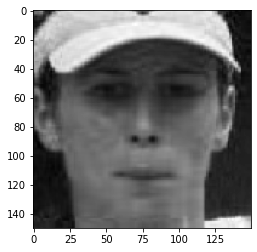

In [13]:
plt.imshow(full_images[11187],cmap = plt.cm.gray)
print(full_images[11187].shape)
print(full_labels[11187])
print(full_labels.shape)
full_images=full_images.reshape(11264,150,150,1) #reshape 

In [14]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)
acc_per_fold = [] #create list for accuracy scores
loss_per_fold = [] #create list for loss scores

# K-fold Cross Validation model evaluation
fold_no = 1 #initialise counter 
for train, test in kfold.split(full_images, full_labels): #run for each fold
    model = model_builder() #build model
    train = np.asarray(train) #convert list to Numpy array
    test = np.asarray(test) #convert list to Numpy array
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print('Training for fold ' + str(fold_no) + ' ...')

    history = model.fit(full_images[train], full_labels[train], batch_size = minibatch,
          verbose = 1, epochs=epochs) #fit model on current train:test split
                  
    # Generate generalization metrics
    scores = model.evaluate(full_images[test], full_labels[test], verbose=0) #evaluate performance of model on test set
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100) #add fold accuracy to list
    loss_per_fold.append(scores[0]) #add fold loss to list
    fold_no += 1 #increase counter

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
317/317 [==============================] - 52s 66ms/step - loss: 8.7721 - accuracy: 0.8491
Epoch 2/10
317/317 [==============================] - 19s 61ms/step - loss: 1.0620 - accuracy: 0.9558
Epoch 3/10
317/317 [==============================] - 19s 61ms/step - loss: 0.5239 - accuracy: 0.9728
Epoch 4/10
317/317 [==============================] - 19s 61ms/step - loss: 0.3304 - accuracy: 0.9790
Epoch 5/10
317/317 [==============================] - 20s 62ms/step - loss: 0.2893 - accuracy: 0.9744
Epoch 6/10
317/317 [==============================] - 20s 62ms/step - loss: 0.1975 - accuracy: 0.9859
Epoch 7/10
317/317 [==============================] - 19s 61ms/step - loss: 0.2059 - accuracy: 0.9842
Epoch 8/10
317/317 [==============================] - 19s 61ms/step - loss: 0.1612 - accuracy: 0.9854
Epoch 9/10
317/317 [==============================] - 19s 61ms/step - loss: 0.1606 - ac

In [43]:
mean_loss = sum(loss_per_fold)/len(loss_per_fold)
mean_acc = sum(acc_per_fold)/len(acc_per_fold)
std_loss = statistics.pstdev(loss_per_fold)
std_acc = statistics.pstdev(acc_per_fold)
max_loss = max(loss_per_fold)
min_loss = min(loss_per_fold)
max_acc = max(acc_per_fold)
min_acc = min(acc_per_fold)
print("Mean Loss: "+ str(mean_loss))
print("Mean Accuracy: "+ str(mean_acc))
print("Standard Deviation Loss: "+ str(std_loss))
print("Standard Deviation Accuracy: "+ str(std_acc))
print("Max Loss: "+ str(max_loss))
print("Max Accuracy: "+ str(max_acc))
print("Min Loss: "+ str(min_loss))
print("Minn Accuracy: "+ str(min_acc))

Mean Loss: 0.22183919847011566
Mean Accuracy: 95.91626346111298
Standard Deviation Loss: 0.06391333004298898
Standard Deviation Accuracy: 2.147449983088597
Max Loss: 0.3583182692527771
Max Accuracy: 98.84546995162964
Min Loss: 0.13448548316955566
Minn Accuracy: 92.01419949531555


In [16]:
model1 = model_builder() #build model
history1 = model1.fit(full_images, full_labels, batch_size = minibatch,
    verbose = 1, epochs=epochs) #fit model on current train:test split

Epoch 1/10
352/352 [==============================] - 22s 61ms/step - loss: 8.1513 - accuracy: 0.8670
Epoch 2/10
352/352 [==============================] - 21s 61ms/step - loss: 0.9575 - accuracy: 0.9652
Epoch 3/10
352/352 [==============================] - 21s 61ms/step - loss: 0.5084 - accuracy: 0.9743
Epoch 4/10
352/352 [==============================] - 21s 61ms/step - loss: 0.3148 - accuracy: 0.9769
Epoch 5/10
352/352 [==============================] - 21s 61ms/step - loss: 0.2288 - accuracy: 0.9828
Epoch 6/10
352/352 [==============================] - 21s 61ms/step - loss: 0.1956 - accuracy: 0.9789
Epoch 7/10
352/352 [==============================] - 21s 61ms/step - loss: 0.1752 - accuracy: 0.9843
Epoch 8/10
352/352 [==============================] - 21s 61ms/step - loss: 0.1530 - accuracy: 0.9857
Epoch 9/10
352/352 [==============================] - 21s 60ms/step - loss: 0.1538 - accuracy: 0.9851
Epoch 10/10
352/352 [==============================] - 21s 61ms/step - loss: 0.130

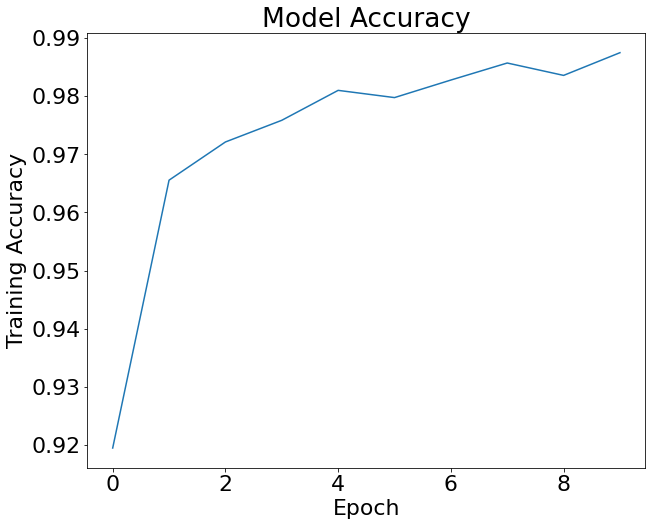

In [49]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})
plt.plot(history1.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

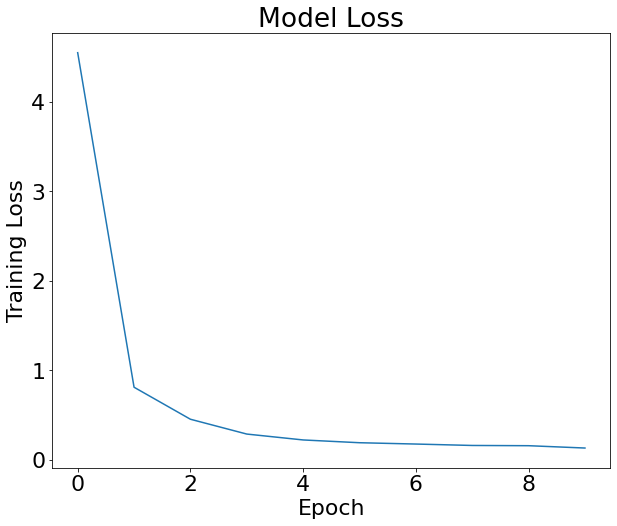

In [50]:
plt.figure(figsize=(10,8))
plt.plot(history1.history['loss'])
plt.title('Model Loss')
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

In [19]:
model1.save("facemask.h5")
saved_model = tf.keras.models.load_model("facemask.h5")

In [32]:
new_img1 = keras.preprocessing.image.load_img('/content/gdrive/My Drive/Colab Notebooks/facemask/ben_no.PNG', target_size=(150,150))
new_img2 = keras.preprocessing.image.load_img('/content/gdrive/My Drive/Colab Notebooks/facemask/ben_yes.jpg', target_size=(150,150))


In [33]:
img_array1 = keras.preprocessing.image.img_to_array(new_img1)
img_array2 = keras.preprocessing.image.img_to_array(new_img2)
img1 = tf.image.rgb_to_grayscale(img_array1, name=None)
img1 = keras.preprocessing.image.img_to_array(img1)
img1 = np.reshape(img1, (150,150))
img1 = img1/255

img2 = tf.image.rgb_to_grayscale(img_array2, name=None)
img2 = keras.preprocessing.image.img_to_array(img2)
img2 = np.reshape(img2, (150,150))
img2 = img2/255




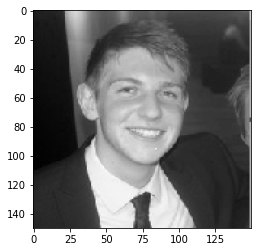

In [34]:
plt.imshow(img1,cmap = plt.cm.gray)
img1=img1.reshape(1,150,150,1)

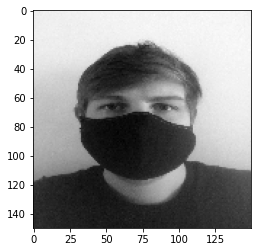

In [35]:
plt.imshow(img2,cmap = plt.cm.gray)
img2=img2.reshape(1,150,150,1)

In [38]:
predictions1 = model1.predict(img1)
if predictions1 > 0.5:
  predictions1_guess = "without face mask"
else:
  predictions1_guess = "with face mask"
print("Image 1 Predicted: " + predictions1_guess + ". Sigmoid Probability: " + str(predictions1) + " Actual : 1 = Without face mask")
predictions2 = model1.predict(img2)
if predictions2 > 0.5:
  predictions2_guess = "without face mask"
else:
  predictions2_guess = "with face mask"
print("Image 2 Predicted: " + predictions2_guess + ". Sigmoid Probability: " + str(predictions2) + " Actual : 0 = With face mask")


Image 1 Predicted: without face mask. Sigmoid Probability: [[0.99246395]] Actual : 1 = Without face mask
Image 2 Predicted: with face mask. Sigmoid Probability: [[0.04949786]] Actual : 0 = With face mask
